<a href="https://colab.research.google.com/github/KUNG1227/ML.EX/blob/main/Sequenc_LinearRegression_MultiOutputRegressor_lag_EX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
import pandas as pd

In [62]:
df = pd.read_csv('/content/load_feature_newdata.csv')

In [63]:
df.head()

,day,Pan1F,Pan2F,Liu1F,Liu2F,是否放假,測站氣壓(hPa),海平面氣壓(hPa),氣溫(℃),露點溫度(℃),相對溼度(%),風速(m-s),風向(360degree),最大瞬間風(m-s),最大瞬間風風向(360degree),降水量(mm),降水時數(h),日照時數(h),全天空日射量(MJ-㎡),紫外線指數
0,2023-01-20 00,0.19,0.16,0.31,0.17,1,1012.0,1013.1,21.6,17.6,78,1.2,340,2.9,360,0.0,0.0,0.0,0.0,0
1,2023-01-20 01,0.15,0.11,0.23,0.88,1,1012.0,1013.1,21.5,17.5,78,1.5,350,2.9,340,0.0,0.0,0.0,0.0,0
2,2023-01-20 02,0.18,0.10,0.23,0.78,1,1011.8,1012.9,21.6,17.2,76,0.7,360,3.0,340,0.0,0.0,0.0,0.0,0
3,2023-01-20 03,0.15,0.10,0.23,0.73,1,1011.6,1012.7,21.4,17.4,78,0.3,290,1.5,310,0.0,0.0,0.0,0.0,0
4,2023-01-20 04,0.18,0.10,0.23,0.72,1,1012.0,1013.1,21.7,17.7,78,0.6,150,1.3,140,0.0,0.0,0.0,0.0,0


為了使用ML演算法預測時間序列，需要將序列轉換為可以與這些演算法一起使用的資料框架。** （除非只使用趨勢和季節性等確定性特徵。）

以下說明如何準備類似於定義預測數字的資料集：一個三步預測任務，使用五個滯後特徵，具有兩步交貨時間。 原始時間序列是y_step_1。 我們可以填寫或刪除缺失的值。

初始化时间序列

创建滞后特征

创建多步预测目标

并特征和目标

置DataFrame样式

In [18]:
N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2023-01-20 00', freq='H', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)
# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

环境设置和Matplotlib默认配置

多步预测可视化函数 plot_multistep:(

  参数：
y: 包含多步预测数据的DataFrame。
every: 指定间隔多少行绘制一次预测曲线。
ax: 指定绘图的轴。如果未提供，则新建一个。
palette_kwargs: 用于自定义颜色板的参数。

功能：
使用Seaborn生成颜色板，为不同的预测曲线提供颜色。
遍历y中的每行数据，将每行数据的索引设置为从该行对应日期开始的时间段，并在指定的轴上绘制预测曲线。)

数据加载和预处理

In [19]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax



data_dir = Path("../input/content/load_feature_newdata.csv")
flu_trends = pd.read_csv(
    data_dir / "/content/load_feature_newdata.csv",
    usecols=['day', 'Pan1F', 'Pan2F', 'Liu1F' , 'Liu2F'],  # 只选择这些列
    parse_dates=['day'],
)
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.day, freq="H"),
    inplace=True,
)
flu_trends.drop("day", axis=1, inplace=True)


In [20]:
flu_trends.head()

,Pan1F,Pan2F,Liu1F,Liu2F
day,,,,
2023-01-20 00:00,0.19,0.16,0.31,0.17
2023-01-20 01:00,0.15,0.11,0.23,0.88
2023-01-20 02:00,0.18,0.10,0.23,0.78
2023-01-20 03:00,0.15,0.10,0.23,0.73
2023-01-20 04:00,0.18,0.10,0.23,0.72


创建滞后特征:(
  
 make_lags 函数用于生成给定时间序列的滞后特征。它接收一个时间序列 ts、滞后的步数 lags 和领先时间 lead_time。
pd.concat 用于沿着列方向（axis=1）合并多个Series，每个Series是原始时间序列向后移动（滞后）若干步得到的。
例如，如果 lead_time=1，lags=4，则会生成 y_lag_1 到 y_lag_4 四个滞后特征，分别对应原始时间序列向后移动1到4步的结果。
这些滞后特征有助于模型学习时间序列中的依赖性，即如何使用前几个时间点的值来预测当前值。

创建多步预测目标

make_multistep_target 函数用于生成多步预测目标。它接收一个时间序列 ts 和预测步数 steps。
类似pd.concat 合并多个Series，每个Series是原始时间序列向前移动（领先）若干步得到的。
例如，steps=8 时，会生成从 y_step_1 到 y_step_8 的八个预测目标，分别对应原始时间序列向前移动1到8步的结果。
这些预测目标用于训练模型进行未来值的多步预测。


处理索引不匹配的问题

在创建滞后特征和多步预测目标后，可能会遇到索引不匹配的问题，因为滞后操作和领先操作改变了原始时间序列的索引。
使用 y.align(X, join='inner', axis=0) 对齐 y 和 X 的索引，选择同时存在于两者中的时间点，确保训练集和目标集在时间上一一对应。
join='inner' 确保只保留 y 和 X 都有的索引，从而解决因移动操作导致的索引不匹配问题。

In [21]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.Pan1F.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

数据集分割

模型训练-線性回歸LinearRegression

模型预测



In [22]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

模型性能评估

可视化预测结果

Train RMSE: 0.38
Test RMSE: 0.22


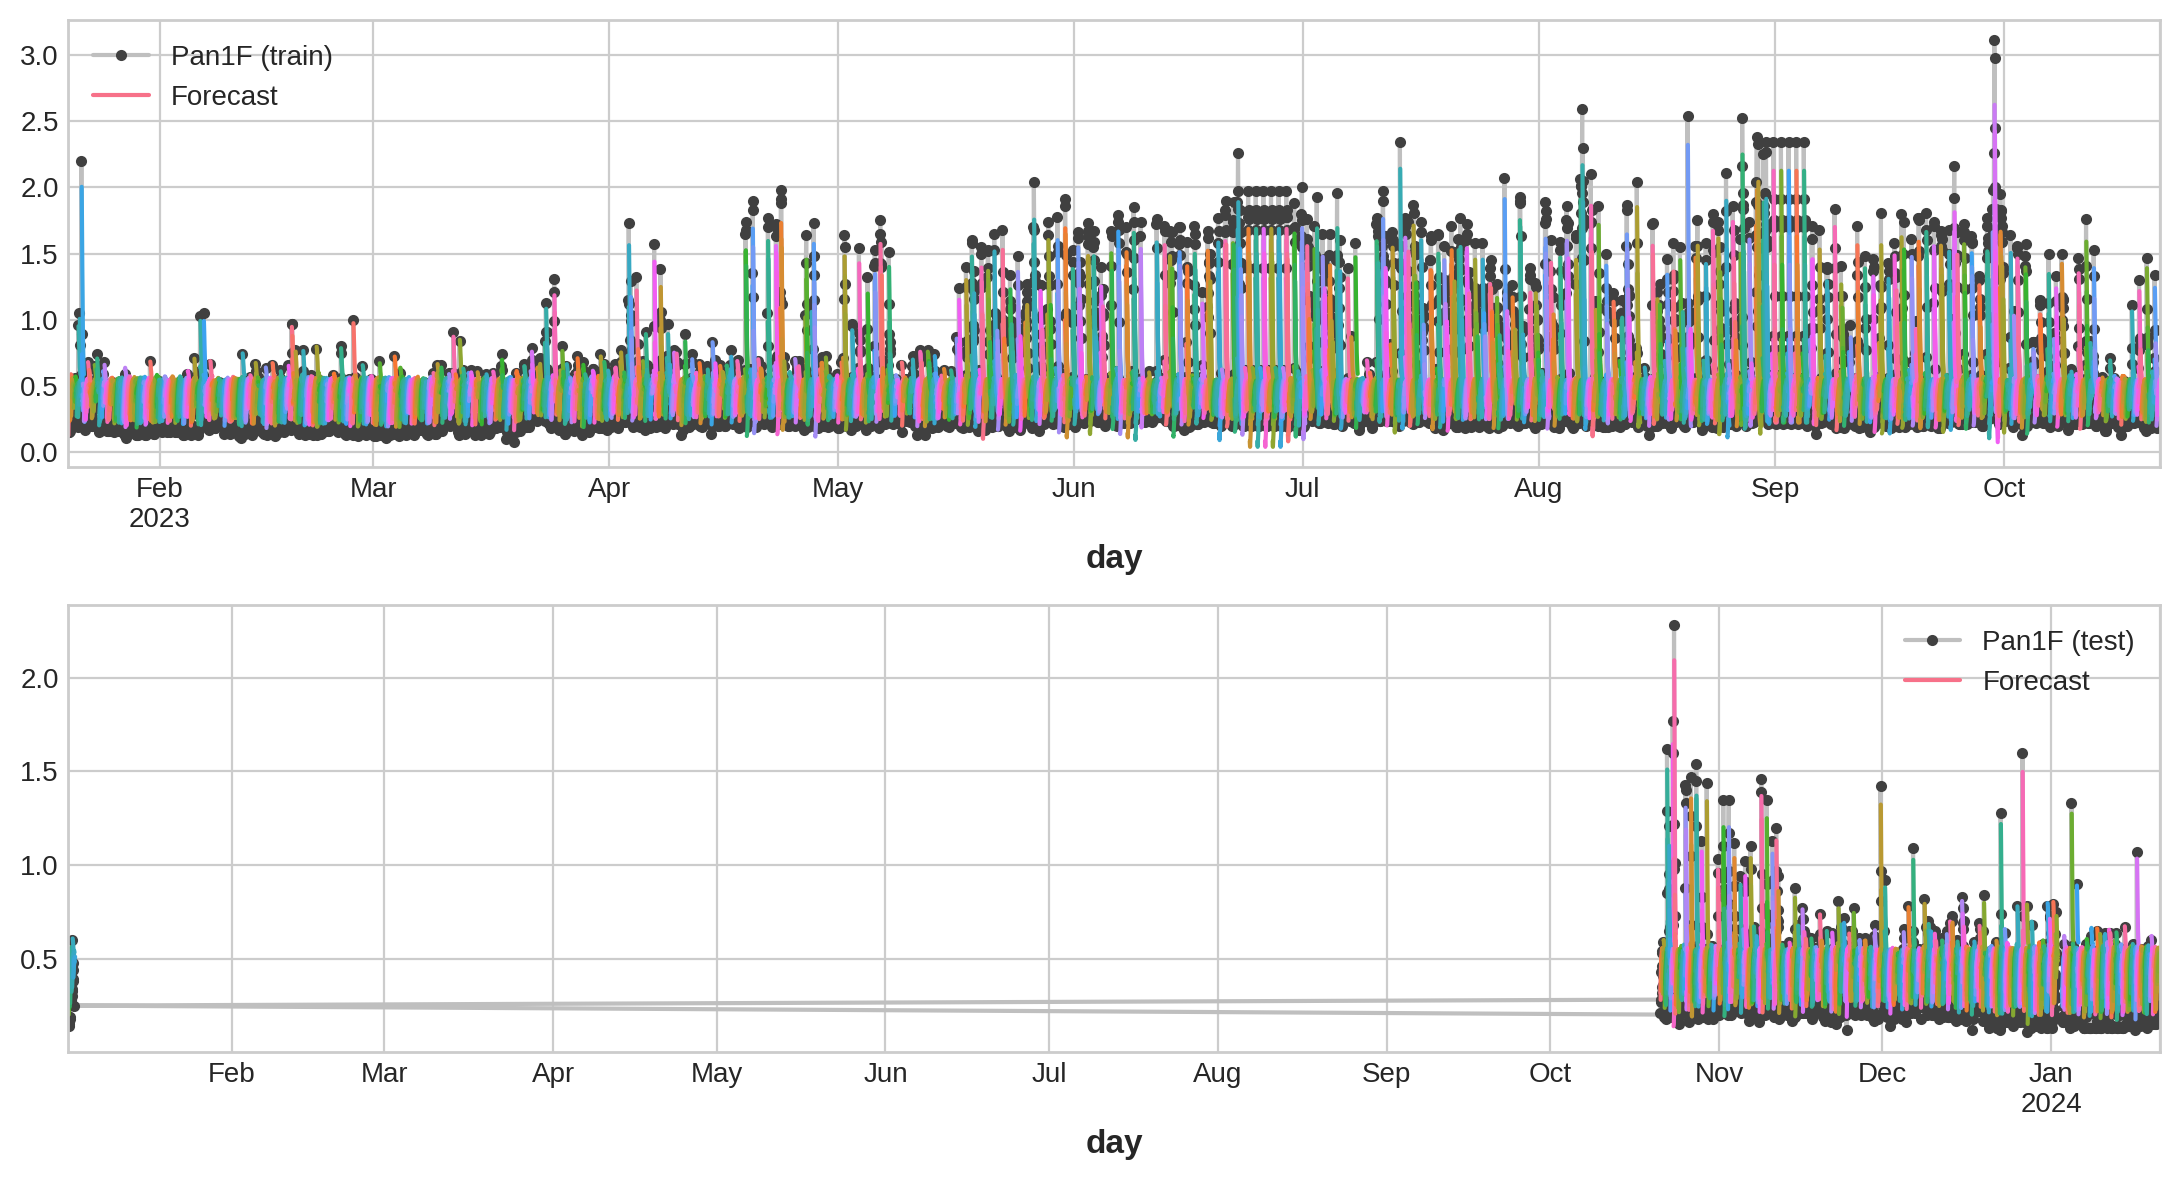

In [23]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.Pan1F[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Pan1F (train)', 'Forecast'])
ax2 = flu_trends.Pan1F[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Pan1F (test)', 'Forecast'])

模型训练- XGBoost 的回歸模型

模型预测


In [24]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 0.23
Test RMSE: 0.26


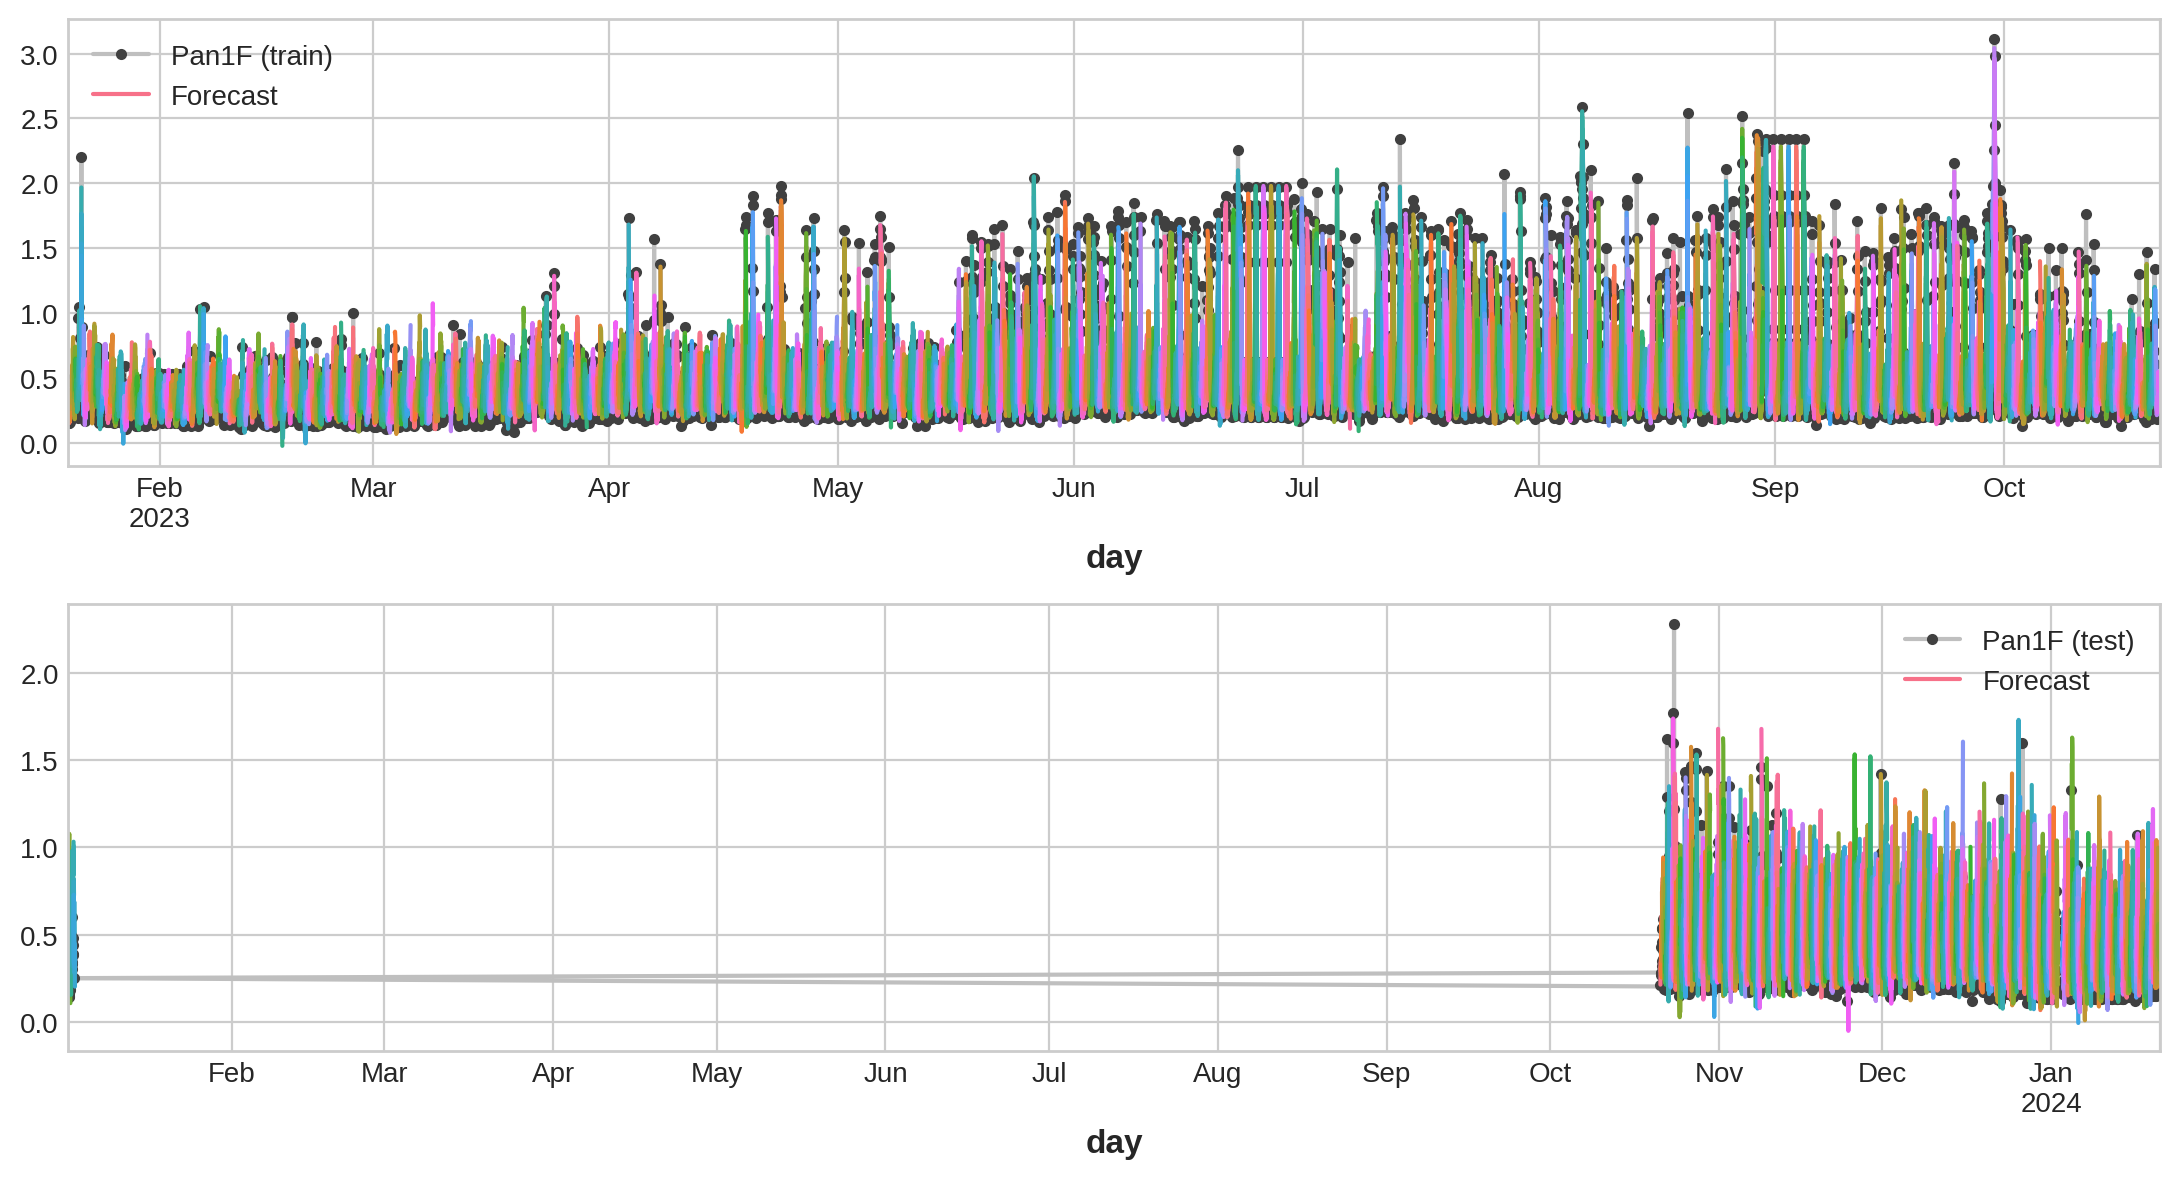

In [25]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.Pan1F[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Pan1F (train)', 'Forecast'])
ax2 = flu_trends.Pan1F[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Pan1F (test)', 'Forecast'])